In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
print(torch.tensor([[1,2],[3,4]]))

tensor([[1, 2],
        [3, 4]])


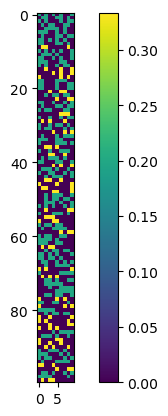

In [4]:
def make_data(N):
    obj = 10
    instances = np.zeros((N,obj))
    index = np.random.choice(np.arange(N),size=N//2)
    label = np.array([])
    for i in range(N):
        if i in index:
            sub = 3
            slot = np.random.choice(np.arange(obj),size=(sub,),replace=False)
            instances[i][slot] = 1/sub
            label = np.append(label,0)
        else:
            sub = 5
            slot = np.random.choice(np.arange(obj),size=(sub,),replace=False)
            instances[i][slot] = 1/sub
            label = np.append(label,1)
    return torch.FloatTensor(instances.reshape(N,obj,1)) , torch.FloatTensor(label.reshape(-1,1))

X,y = make_data(100)
plt.imshow(X)
plt.colorbar()
plt.show()

In [5]:
class DeepSet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.element_wise = torch.nn.Sequential(
            torch.nn.Linear(1,5),
            torch.nn.Tanh(),
            torch.nn.Linear(5,5),
            torch.nn.Tanh(),
            torch.nn.Linear(5,1),
        )
        self.global_net = torch.nn.Sequential(
            torch.nn.Linear(1,5),
            torch.nn.Tanh(),
            torch.nn.Linear(5,1),
            torch.nn.Sigmoid()
        )
    def forward(self,X):
        inp = X.reshape(-1,1)
        H = self.element_wise(inp)
        H = H.reshape(-1,10,1)
        pooled = H.sum(axis=1)
        out = self.global_net(pooled)
        return out

In [6]:
MLP = lambda Nhidden = 5 : torch.nn.Sequential(
                                                torch.nn.Flatten(),
                                                torch.nn.Linear(10,Nhidden),
                                                torch.nn.ReLU(),
                                                torch.nn.Linear(Nhidden,Nhidden),
                                                torch.nn.ReLU(),
                                                torch.nn.Linear(Nhidden,1),
                                                torch.nn.Sigmoid()
                                                )

In [7]:
def train(model):
    optim = torch.optim.Adam(model.parameters(),1e-3)
    traj = np.array([])
    for i in range(4000):
        X,y = make_data(100)
        data = model(X)
        loss = torch.nn.functional.binary_cross_entropy(data,y)
        traj = np.append(traj,float(loss))
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 500 == 0:
            print(f"{i}: {float(loss)}")
    return model,traj

In [8]:
print("Model: DeepSet")
trained_deepset,losscurve_deepset = train(DeepSet())
print("Model: MLP")
trained_mlp,losscurve_mlp = train(MLP())

Model: DeepSet
0: 0.7551955580711365
500: 0.6645658612251282
1000: 0.6892393231391907
1500: 0.10198661684989929
2000: 0.0190895888954401
2500: 0.009425907395780087
3000: 0.005602364428341389
3500: 0.003794766031205654
Model: MLP
0: 0.6592243909835815
500: 0.6473917961120605
1000: 0.6275722980499268
1500: 0.5827395915985107
2000: 0.537265419960022
2500: 0.6257405281066895
3000: 0.5068119764328003
3500: 0.558834969997406


In [9]:
def count_params(model):
    return sum([param.numel() for param in model.parameters()])

In [10]:
N_DeepSet = count_params(trained_deepset)
N_MLP = count_params(trained_mlp)

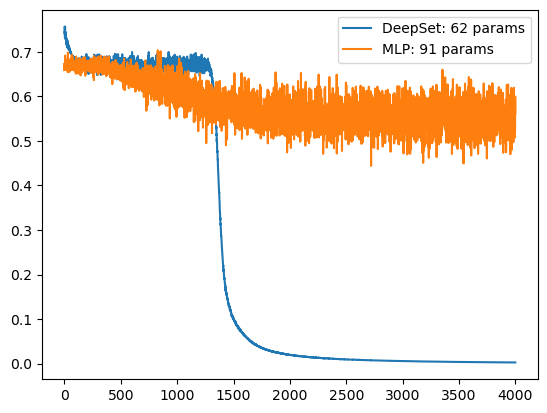

In [13]:
plt.figure()
plt.plot(losscurve_deepset,label=f"DeepSet: {N_DeepSet} params")
plt.plot(losscurve_mlp,label=f"MLP: {N_MLP} params")
plt.legend()
plt.show()

In [14]:
perm0 = np.random.permutation(10)
perm1 = np.random.permutation(10)
perm2 = np.random.permutation(10)


testX1 = torch.FloatTensor(X[0][perm0]).reshape(1,10,1)
testX2 = torch.FloatTensor(X[0][perm1]).reshape(1,10,1)
testX3 = torch.FloatTensor(X[0][perm2]).reshape(1,10,1)

print('DeepSet')
for XX in [testX1,testX2,testX3]:
    print(trained_deepset(XX))

print('MLP')
for XX in [testX1,testX2,testX3]:
    print(trained_mlp(XX))

DeepSet
tensor([[0.9979]], grad_fn=<SigmoidBackward0>)
tensor([[0.9979]], grad_fn=<SigmoidBackward0>)
tensor([[0.9979]], grad_fn=<SigmoidBackward0>)
MLP
tensor([[0.4450]], grad_fn=<SigmoidBackward0>)
tensor([[0.8972]], grad_fn=<SigmoidBackward0>)
tensor([[0.4403]], grad_fn=<SigmoidBackward0>)
